# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

from utils.load_filters_for_primer import get_filters
from utils.load_filters_for_primer import get_filters_multi_scale

np.set_printoptions(precision=3, suppress=True)

# declare hyperparameters

In [61]:
PATCH_SIZE = 7  # 28/7=4 which is convenient
# FILTER_THRESHOLD = 0.6  # was ok for digit 0-3 and 2 multi-scale filters
FILTER_THRESHOLD = 0.7
CLUSTER_DISTANCE = 3  # distance within primers that are considered as identical
DECREASE_END_FACTOR = 0.6  # factor that decrease an end weight after being used
TYPE_FACTORS1 = [1.0, 0.9, 0.85, 0.5, 0.8, 0.001]  # for primers 0-3   ends
TYPE_FACTORS2 = [1.0, 0.8, 0.8, 0.5, 0.7, 0.001]  # for primers 4-7   Ts
TYPE_FACTORS3 = [0.9, 1.0, 0.9, 0.8, 1.0, 0.001]  # for primers 8-11  corners
TYPE_FACTORS4 = [0.9, 1.0, 1.0, 0.8, 1.0, 0.001]  # for primers 12    cross

# load data

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

shape test_image (28, 28)


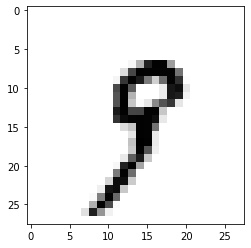

In [30]:
# idx = 0  # label 5
# idx = 1  # label 0
# idx = 2  # label 4
# idx = 3  # label 1
# idx = 4  # label 9
# idx = 5  # label 2
# idx = 7  # label 3
# idx = 9  # label 4
# idx = 10  # label 3
# idx = 11  # label 5
# idx = 12  # label 3
# idx = 13  # label 6
# idx = 16  # label 2
# idx = 17  # label 8
# idx = 18  # label 6
idx = 19  # label 9
test_image = x_train[idx]
print("shape test_image", np.shape(test_image))
plt.imshow(test_image, cmap='Greys')

# compute bank of primers

In [31]:
def compute_center_of_activity(ft_map, verbose=False):
    # initialize indices (x, y) for each entry
    indices = np.arange(np.shape(ft_map)[0])

    # compute weighted average of the activity, weighted by the indices
    average_x = np.average(ft_map, axis=1, weights=indices)
    average_y = np.average(ft_map, axis=0, weights=indices)

    # compute mean of each pos
    center_x = np.sum(average_x) * np.sum(indices) / np.sum(np.sum(ft_map + 1e-7, axis=1))
    center_y = np.sum(average_y) * np.sum(indices) / np.sum(np.sum(ft_map + 1e-7, axis=0))

    if verbose:
        print("feat_map")
        print(ft_map)
        print("center ({}, {})".format(center_x, center_y))

    return center_x, center_y

In [32]:
# test cell
ft_map = np.zeros((7, 7))
ft_map[4, 4] = 1
# ft_map[0, 1] = 1

compute_center_of_activity(ft_map, verbose=True)

feat_map
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
center (3.999980400096039, 3.999980400096039)


(3.999980400096039, 3.999980400096039)

In [33]:
def find_primer(image, filters, patch_size=7, threshold=0.5, do_plot=False, verbose=False, plot_title=""):
    # convert image to tensor
    if len(np.shape(image)) == 2:
        image = np.expand_dims(image, axis=[0, 3])
    else:
        print("image shape is wrong! Expected 2 got ", len(np.shape(image)))
    image = tf.convert_to_tensor(image, dtype='float32')

    # control filters
    if len(np.shape(filters)) == 2:
        filters = np.expand_dims(filters, axis=[2, 3])
    elif len(np.shape(filters)) == 3:  # multi scale
        filters = np.expand_dims(filters, axis=2)
    tf.convert_to_tensor(filters, dtype='float32')

    # apply convolution
    primers = tf.nn.conv2d(image, filters, strides=1, padding='SAME', name="conv1")

    if verbose:
        print("min max patch", np.min(primers), np.max(primers))

    # filters primers and discard the one under the threshold
    filt_primers = primers.numpy()
    filt_primers = np.amax(filt_primers, axis=(0, -1))
    filt_primers = np.expand_dims(filt_primers, axis=[0, 3])
    filt_primers[filt_primers < threshold] = 0
    if np.max(filt_primers) > 1:
        print("Max of nb_primers is greater than 1! This could mean that the the filter is not normalized, imaged clamped to 1 to avoid issues with the center of activity")
        filt_primers[filt_primers > 1] = 1.0

    # split in patches
    patches = tf.image.extract_patches(
        images=filt_primers,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()

    # show each patch
    if do_plot:
        plt.figure()
        plt.title("patch " + plot_title)
        for i in range(np.shape(patches)[1]):
            for j in range(np.shape(patches)[2]):
                patch = np.reshape(patches[0, i, j], [patch_size, patch_size])
                rgb_patch = np.repeat(np.expand_dims(patch, axis=2), 3, axis=2)
                plt.subplot(4, 4, i*np.shape(patches)[2] + j + 1)
                plt.axis('off')
                plt.imshow(rgb_patch)
                # print("min max patch", np.min(patch), np.max(patch))

    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                if verbose:
                    print()
                    print("p:", plot_title)

                coa = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([coa[0] + j*patch_size, coa[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    if do_plot:
        # plot primers
        plt.figure()
        plt.title("primers " + plot_title)
        rgb_image = np.repeat(np.expand_dims(filt_primers[0, ..., 0], axis=2), 3, axis=2)
        for center in centers:
            rgb_image[int(round(center[1])), int(round(center[0]))] = [1.0, 0, 0]
        plt.imshow(rgb_image)

    return centers, max_patch

In [34]:
# compute all primers
def find_primers(image, filters, patch_size=7, threshold=0.5, do_plot=False, verbose=False):
    n_primer = 0
    primers = {}

    for p, filt in enumerate(filters):
        if verbose:
            print("filt p", p)

        primers_pos, max_patch = find_primer(image, filt,
                                             patch_size=patch_size,
                                             threshold=threshold,
                                             do_plot=do_plot,
                                             verbose=verbose,
                                             plot_title=str(p))

        if len(primers_pos) > 0:
            for i in range(len(primers_pos)):
                primers[n_primer] = {"type": p, "pos": primers_pos[i], "max": max_patch[i]}
                n_primer += 1

            if verbose:
                print("primers_pos")
                print(primers_pos)
                print("max patch")
                print(max_patch)
        if verbose:
            print()

    return primers

shape ends_filters (4, 7, 7, 9)
shape corners_filters (4, 7, 7, 9)
shape T_filters (4, 7, 7, 9)
shape cross_filters (1, 7, 7, 9)
shape filters (13, 7, 7, 9)
filt p 0
min max patch -4.031999 0.5468137

filt p 1
min max patch -4.6245375 0.6564441

filt p 2
min max patch -4.233844 0.7159315

p: 2
feat_map
[[0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.716 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]
center (1.9999860133118301, 4.999965449547181)
primers_pos
[[8.99998601331183, 25.999965449547183]]
max patch
[0.7159315]

filt p 3
min max patch -4.3597846 0.47826797

filt p 4
min max patch -0.6293028 0.58965135

filt p 5
min max patch -0.57135075 0.53986925

filt p 6
min max patch -0.6413943 0.60294116

filt p 7
min max patch -0.6118736 0.5718955

filt p 8
min max patch -2.7

/Users/michaelstettler/PycharmProjects/BVS/BVS/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



p: 10
feat_map
[[0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.776 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]
center (3.99997420761138, 3.99997420761138)
primers_pos
[[17.99997420761138, 10.99997420761138]]
max patch
[0.7764706]

filt p 11
min max patch -3.094398 0.9132352


/Users/michaelstettler/PycharmProjects/BVS/BVS/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



p: 11
feat_map
[[0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.79  0.913 0.    0.   ]
 [0.    0.    0.    0.    0.875 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]
center (3.6935651856236476, 1.3393040269325391)
primers_pos
[[17.693565185623648, 8.339304026932538]]
max patch
[0.9132352]

filt p 12
min max patch -1.1830244 0.5619378

primers_dict
{'type': 2, 'pos': [8.99998601331183, 25.999965449547183], 'max': 0.7159315}
{'type': 8, 'pos': [12.499126866357193, 9.013826585482228], 'max': 0.79918295}
{'type': 9, 'pos': [11.999969377746854, 12.999962805168469], 'max': 0.7980391}
{'type': 10, 'pos': [17.99997420761138, 10.99997420761138], 'max': 0.7764706}
{'type': 11, 'pos': [17.693565185623648, 8.339304026932538], 'max': 0.9132352}


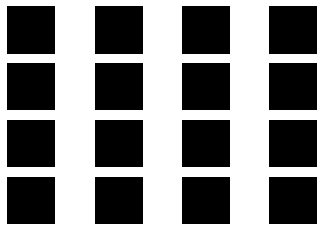

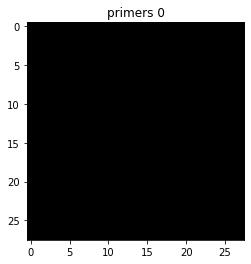

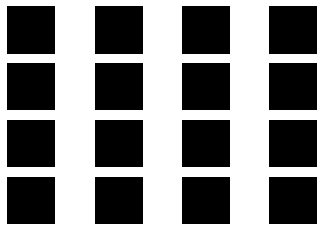

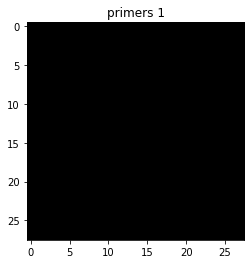

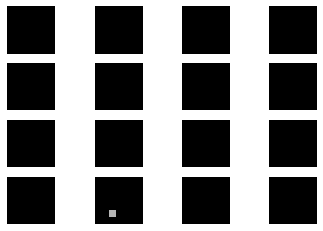

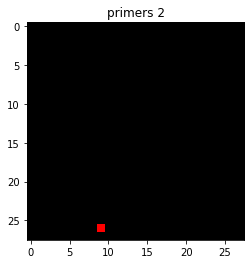

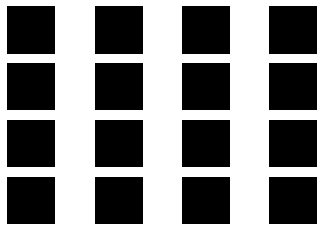

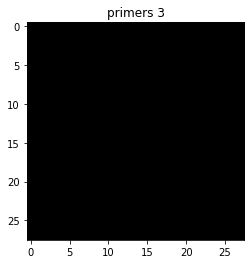

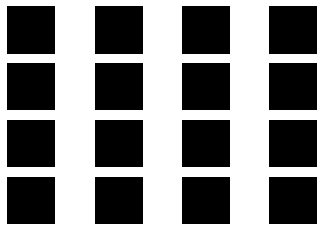

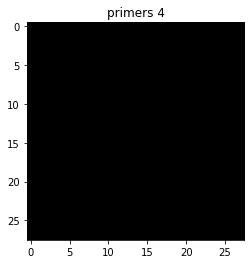

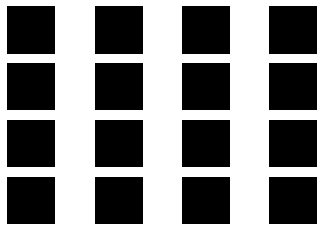

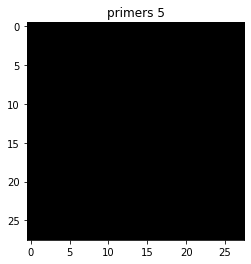

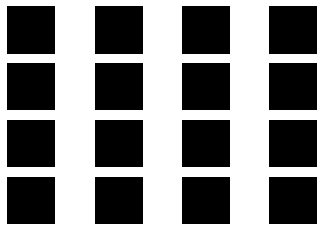

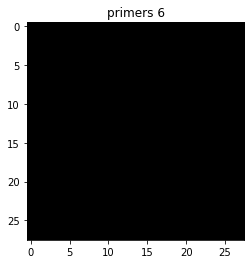

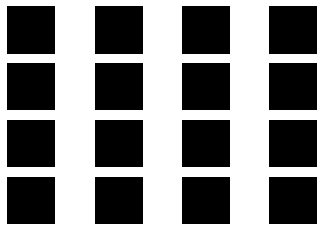

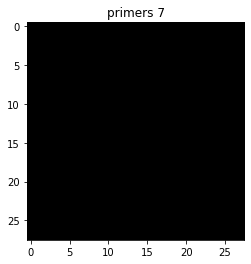

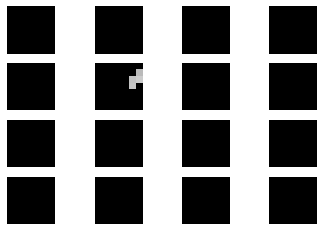

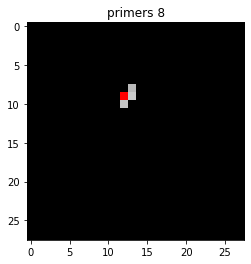

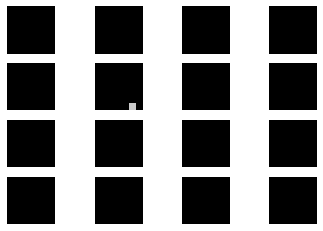

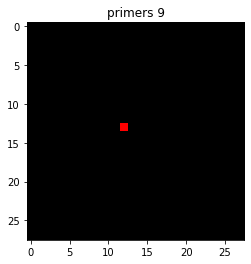

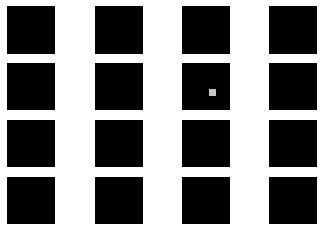

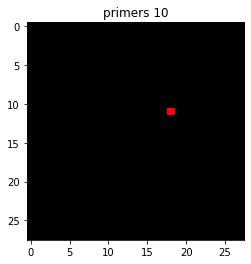

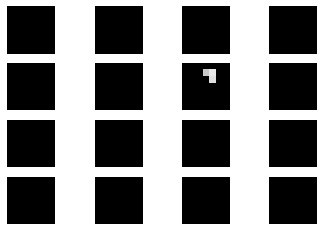

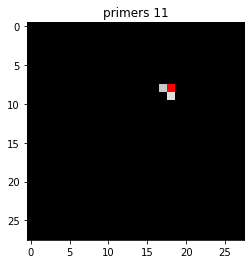

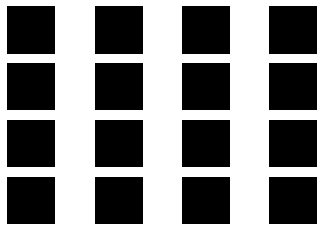

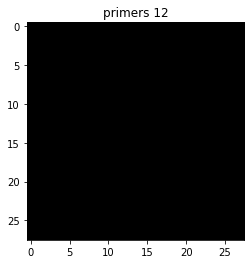

In [35]:
# filters = get_filters()
filters = get_filters_multi_scale()
print("shape filters", np.shape(filters))

# normalize input and filters
test_image_norm = test_image / 255.
primers_dict = find_primers(test_image_norm, filters, patch_size=PATCH_SIZE, threshold=FILTER_THRESHOLD, do_plot=True, verbose=True)
print("primers_dict")
for p in primers_dict:
    print(primers_dict[p])

In [36]:
def max_pool_primers(primers, dist_threshold=3, sorting='max', verbose=False):
    """
    filter primers with surroundings, i.e. if a primer is within a distance smaller than another one, keep the highest

    :param primers:
    :return:
    """

    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(primers)):
        for p_a in range(p_t + 1, len(primers)):  # only upward diagonal
            # get primers
            p_target = primers[p_t]
            p_agent = primers[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance", distance)

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] > p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                    else:
                        discarded_primer_idx.append(p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in primers:
        if p not in discarded_primer_idx:
            primer = primers[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [37]:
filt_primers = max_pool_primers(primers_dict, dist_threshold=CLUSTER_DISTANCE, verbose=True)
print("filt_primers", len(filt_primers))
for p in filt_primers:
    print(filt_primers[p])

distance 17.34280543103534
distance 13.34166290013132
distance 17.49284210057594
distance 19.684442606014603
distance 4.0172677481505135
distance 5.848427468018437
distance 5.238050222616821
distance 6.324556296591565
distance 7.357905508405217
distance 2.678255458149775
discarded primers
[3]
filt_primers 4
{'type': 2, 'pos': [8.99998601331183, 25.999965449547183], 'max': 0.7159315}
{'type': 8, 'pos': [12.499126866357193, 9.013826585482228], 'max': 0.79918295}
{'type': 9, 'pos': [11.999969377746854, 12.999962805168469], 'max': 0.7980391}
{'type': 11, 'pos': [17.693565185623648, 8.339304026932538], 'max': 0.9132352}


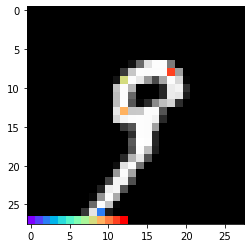

In [38]:
# plot primers on digit
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, np.shape(filters)[0]))
rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

for p in filt_primers:
    primer = filt_primers[p]
    primer_type = primer["type"]
    primer_pos = primer["pos"]
    color = colors[primer_type]
    rgb_im[np.round(primer_pos[1]).astype(int), np.round(primer_pos[0]).astype(int)] = color[:3] * 255

# plot legend
for i in range(np.shape(filters)[0]):
    color = colors[i]
    rgb_im[-1, i] = color[:3] * 255

plt.imshow(rgb_im)

# compute Sequence

In [39]:
def compute_n_vectors(primers, verbose=False):
    n_vectors = 0
    n_ends = 0
    for p in range(len(primers)):
        "ends and T adds only half a vector since we need two to make a vector, while the corner adds a full vector as it is between two others"
        "Ts are considered half since the matching factor draws a vector that 'bypass' the T and thus has only one end to it"
        primer = primers[p]
        if primer["type"] in [0, 1, 2, 3, 4, 5, 6, 7]:
            n_vectors += 0.5
            n_ends +=1
        elif primer["type"] == 12:  # cross adds two vectors
            n_vectors += 2
        else:
            n_vectors += 1

    # remove a vector if there's only one end, that may mean that the other end has not been found because there's some small corner at the tip
    if n_ends%2 != 0:
        n_vectors -= 1

    n_vectors = np.ceil(n_vectors).astype(int)

    if verbose:
        print("Found {} vectors from {} primers".format(n_vectors, len(primers)))
        print()

    return n_vectors

In [40]:
def compute_type_factor_btw_primers(type1, type2):
    factor = TYPE_FACTORS1[-1]

    def go_down(type, type_factors):
        if type == 2:  # I
            factor = type_factors[0]
        elif type == 9:  # |_
            factor = type_factors[1]
        elif type == 10:  # _|
            factor = type_factors[2]
        elif type == 6:  # _|_
            factor = type_factors[3]
        elif type == 12:  # +
            factor = type_factors[4]
        else:
            factor = type_factors[-1]
        return factor

    def go_left(type, type_factors):
        if type == 1:
            factor = type_factors[0]  # -
        elif type == 8:
            factor = type_factors[1]  # -:
        elif type == 9:
            factor = type_factors[2]  # -:|
        elif type == 5:
            factor = type_factors[3]  # -:|
        elif type == 12:
            factor = type_factors[4]
        else:
            factor = type_factors[-1]
        return factor

    def go_up(type, type_factors):
        if type == 0:
            factor = type_factors[0]
        elif type == 11:
            factor = type_factors[1]
        elif type == 8:
            factor = type_factors[2]
        elif type == 4:
            factor = type_factors[3]
        elif type == 12:
            factor = type_factors[4]
        else:
            factor = type_factors[-1]
        return factor

    def go_right(type, type_factors):
        if type == 3:
            factor = type_factors[0]
        elif type == 10:
            factor = type_factors[1]
        elif type == 11:
            factor = type_factors[2]
        elif type == 7:
            factor = type_factors[3]
        elif type == 12:
            factor = type_factors[4]
        else:
            factor = type_factors[-1]
        return factor

    if type1 == 0:
        factor = go_down(type2, TYPE_FACTORS1)
    elif type1 == 1:
        factor = go_right(type2, TYPE_FACTORS1)
    elif type1 == 2:
        factor = go_up(type2, TYPE_FACTORS1)
    elif type1 == 3:
        factor = go_left(type2, TYPE_FACTORS1)

    elif type1 == 4:
        factor = go_down(type2, TYPE_FACTORS2)
    elif type1 == 5:
        factor = go_right(type2, TYPE_FACTORS2)
    elif type1 == 6:
        factor = go_up(type2, TYPE_FACTORS2)
    elif type1 == 7:
        factor = go_left(type2, TYPE_FACTORS2)

    elif type1 == 8:
        factor = go_down(type2, TYPE_FACTORS3)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_right(type2, TYPE_FACTORS3)
    elif type1 == 9:
        factor = go_right(type2, TYPE_FACTORS3)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_up(type2, TYPE_FACTORS3)
    elif type1 == 10:
        factor = go_left(type2, TYPE_FACTORS3)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_up(type2, TYPE_FACTORS3)
    elif type1 == 11:
        factor = go_left(type2, TYPE_FACTORS3)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_down(type2, TYPE_FACTORS3)

    elif type1 == 12:
        factor = go_right(type2, TYPE_FACTORS4)

        if factor == TYPE_FACTORS1[-1]:
            factor = go_down(type2, TYPE_FACTORS4)

            if factor == TYPE_FACTORS1[-1]:
                factor = go_left(type2, TYPE_FACTORS4)

                if factor == TYPE_FACTORS1[-1]:
                    factor = go_up(type2, TYPE_FACTORS4)
    else:
        print("Todo type1:", type1)

    return factor

In [41]:
def compute_distance_btw_primers(pos1, pos2, alpha=3):
    return np.log(np.linalg.norm(np.array(pos1) - np.array(pos2)))

In [42]:
def compute_score_matrix(primers, verbose=False):
    # group primers' positions
    score_mat = np.zeros((len(primers), len(primers)))
    for p_t in range(len(primers)):
        # get target primer
        p_target = primers[p_t]

        if verbose:
            print(p_t, ": primer - ", p_target)

        # compute for full matrix since it may not be symmetric due to the different idx_factors
        for p_a in range(len(primers)):
            if p_a != p_t:  # remove self connections
                # get agent primer
                p_agent = primers[p_a]

                type_factor = compute_type_factor_btw_primers(p_target["type"], p_agent["type"])
                dist = compute_distance_btw_primers(p_target["pos"], p_agent["pos"])
                score = type_factor / dist
                score_mat[p_t, p_a] = score


    if verbose:
        print("score_mat")
        print(score_mat)

    return score_mat

In [43]:
def get_idx_primers_type(primers):
    idx_type1, idx_type2, idx_type3, idx_type4 = [], [], [], []

    for p in primers:
        primer = primers[p]
        type_primer = primer["type"]

        if type_primer in [0, 1, 2, 3]:
            idx_type1.append(p)
        elif type_primer in [4, 5, 6, 7]:
            idx_type2.append(p)
        elif type_primer in [8, 9, 10, 12]:
            idx_type3.append(p)
        else:
            idx_type4.append(p)

    return idx_type1, idx_type2, idx_type3, idx_type4

In [44]:
def set_new_chain_agent(agent, target, verbose=False):

    swap = False
    # agent is a continuity then we start by the other end
    if agent["type"] in [8, 9, 10, 11]:
        swap = True
    # agent is an end (type1) and target is type3, then we start by type3
    elif agent["type"] in [0, 1, 2, 3] and target["type"] in [4, 5, 6, 7]:
        swap = True

    # swap vectors
    if swap:
        agent_copy = agent
        agent = target
        target = agent_copy

        if verbose:
            print("primers swapped between agent and target")

    return agent, target, swap


In [45]:
def build_vector_sequence(score_mat, n_vectors, primers, verbose=False):
    sequence = {}

    # build sequence of primers from the highest matching score
    last_target_idx = None
    n_chain = 0
    for v in range(n_vectors):
        new_chain = False
        if last_target_idx is None:  # new chain
            new_chain = True
            # get idx of the primers per type
            idx_type1, idx_type2, idx_type3, idx_type4 = get_idx_primers_type(primers)

            # first chain need to start with an end primer
            if n_chain == 0:
                # idx_type = idx_type1
                idx_type = [0]  # simply start with index 0?
            else:
            # then the chain can start either from an end or a type3 primer
                idx_type = idx_type1 + idx_type2

            # get sub matrix
            sub_score_mat = score_mat[idx_type, :]

            if verbose:
                print("idx_type")
                print(idx_type)
                print("sub_score_mat")
                print(sub_score_mat)

            # get the highest score
            pair_primers = np.unravel_index(sub_score_mat.argmax(), sub_score_mat.shape)
            # get back idx (from score_mat space for agent_idx)
            agent_idx = idx_type[pair_primers[0]]
            target_idx = pair_primers[1]
        else:  # ongoing chain
            agent_idx = last_target_idx
            # look for the highest score from the previous primer
            target_idx = np.argmax(score_mat[agent_idx, :])

            if verbose:
                print("score mat continuuity")
                print(score_mat[agent_idx, :])

        # retrieve primers from pair
        p_agent = primers[agent_idx]
        p_target = primers[target_idx]

        if new_chain:
            p_agent, p_target, swapped = set_new_chain_agent(p_agent, p_target, verbose=verbose)
        else:
            swapped = False

        if verbose:
            print("highest_match between: {} and {} ({})".format(agent_idx, target_idx, score_mat[agent_idx, target_idx]))
            print("connection between type: {} and {}".format(p_agent["type"], p_target["type"]))

        # append sequence
        sequence[v] = {"type": [p_agent["type"], p_target["type"]], "pos": [p_agent["pos"], p_target["pos"]]}

        # remove score to avoid picking this connection again
        if p_agent["type"] != 12:  # avoid discarding the cross since many vectors will go through it
            score_mat[target_idx, agent_idx] = 0
        else:
            # penalize strongly closer primers from a cross, but they can still go through, the idea is to avoid back and forth
            score_mat[target_idx, agent_idx] *= 1 - score_mat[target_idx, agent_idx]**3

        # remove used connection
        score_mat[agent_idx, target_idx] = 0

        # remove entirely the connections (scores) when it's a type3 that it has been used already twice
        if not new_chain and p_agent["type"] in [8, 9, 10, 11]:
            score_mat[last_target_idx, :] = 0
            score_mat[:, last_target_idx] = 0

        # penalize ends that has already been used (they can still start anew sequence like in an A)
        if p_agent["type"] in [0, 1, 2, 3, 4, 5, 6, 7]:
            score_mat[agent_idx, :] *= DECREASE_END_FACTOR
            score_mat[:, agent_idx] *= DECREASE_END_FACTOR

        # control if chain ends
        if p_target["type"] in [0, 1, 2, 3, 4, 5, 6, 7]:
            # penalize ends so it may look first for another ends to start
            score_mat[target_idx, :] *= DECREASE_END_FACTOR
            score_mat[:, target_idx] *= DECREASE_END_FACTOR

            last_target_idx = None
            n_chain += 1
        else:
            if swapped:
                last_target_idx = agent_idx
            else:
                last_target_idx = target_idx

        if verbose:
            print("sequence")
            for i in range(len(sequence)):
                print(sequence[i])
            print("new score_mat:")
            print(score_mat)
            if last_target_idx is None:
                print("last_target_idx: {}".format(last_target_idx))
            else:
                print("last_target_idx: {} (type: {})".format(last_target_idx, p_target["type"]))
            print()

    return sequence


In [46]:
def group_primers_to_sequence(primers, verbose=False):
    # get score matrix
    score_mat = compute_score_matrix(primers, verbose=verbose)

    # compute n_vectors
    n_vectors = compute_n_vectors(primers, verbose=verbose)

    # compute sequence
    sequence = build_vector_sequence(score_mat, n_vectors, primers, verbose=verbose)

    return sequence

In [51]:
sequence = group_primers_to_sequence(filt_primers, verbose=True)
print("Final sequence")
for s in sequence:
    print(sequence[s])

# [0.    0.    0.389 0.361 0.456]

0 : primer -  {'type': 2, 'pos': [8.99998601331183, 25.999965449547183], 'max': 0.7159315}
1 : primer -  {'type': 8, 'pos': [12.499126866357193, 9.013826585482228], 'max': 0.79918295}
2 : primer -  {'type': 9, 'pos': [11.999969377746854, 12.999962805168469], 'max': 0.7980391}
3 : primer -  {'type': 11, 'pos': [17.693565185623648, 8.339304026932538], 'max': 0.9132352}
score_mat
[[0.    0.28  0.    0.302]
 [0.315 0.    0.719 0.543]
 [0.    0.647 0.    0.451]
 [0.302 0.604 0.451 0.   ]]
Found 3 vectors from 4 primers

idx_type
[0]
sub_score_mat
[[0.    0.28  0.    0.302]]
highest_match between: 0 and 3 (0.30203079381343667)
connection between type: 2 and 11
sequence
{'type': [2, 11], 'pos': [[8.99998601331183, 25.999965449547183], [17.693565185623648, 8.339304026932538]]}
new score_mat:
[[0.    0.168 0.    0.   ]
 [0.189 0.    0.719 0.543]
 [0.    0.647 0.    0.451]
 [0.    0.604 0.451 0.   ]]
last_target_idx: 3 (type: 11)

score mat continuuity
[0.    0.604 0.451 0.   ]
highest_match bet

In [52]:
def plot_vectors(image, sequence, fig=None, subplot=None, title=None):

    if fig is None:
        plt.figure()
    else:
        fig.add_subplot(subplot)
        plt.title(title)

    colors = cm.rainbow(np.linspace(0, 1, len(sequence)))
    for s, color in zip(sequence, colors):
        vector = sequence[s]["pos"]

        # add vectors
        vector = np.rint(vector).astype(int)
        # plt.plot([vector[0, 0], vector[1, 0]],[vector[0, 1], vector[1, 1]], color=color, linestyle='solid', marker='o', linewidth=3)
        plt.arrow(vector[0, 0], vector[0, 1], vector[1, 0] - vector[0, 0], vector[1, 1]-vector[0, 1],
                  color=color,
                  linestyle='solid',
                  width=0.5,
                  length_includes_head=True)

    # show image
    plt.imshow(image)

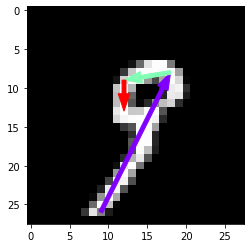

In [53]:
rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)
plot_vectors(rgb_im, sequence)

# VECTORIZE ENTIRE DIGIT

In [54]:
def vectorize_digit(image, filters, do_plot=False, verbose=False):
    # find primers
    primers_dict = find_primers(image, filters, patch_size=PATCH_SIZE, threshold=FILTER_THRESHOLD, do_plot=do_plot, verbose=verbose)

    # clearn primers
    filt_primers = max_pool_primers(primers_dict, dist_threshold=CLUSTER_DISTANCE, verbose=verbose)

    # compute vectors
    sequence = group_primers_to_sequence(filt_primers, verbose=verbose)

    return sequence

shape test_image (28, 28)
shape ends_filters (4, 7, 7, 9)
shape corners_filters (4, 7, 7, 9)
shape T_filters (4, 7, 7, 9)
shape cross_filters (1, 7, 7, 9)
{'type': [2, 11], 'pos': [[8.99998601331183, 25.999965449547183], [17.693565185623648, 8.339304026932538]]}
{'type': [11, 8], 'pos': [[17.693565185623648, 8.339304026932538], [12.499126866357193, 9.013826585482228]]}
{'type': [8, 9], 'pos': [[12.499126866357193, 9.013826585482228], [11.999969377746854, 12.999962805168469]]}


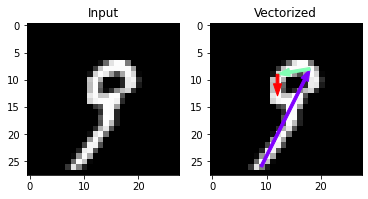

In [59]:
# idx = 0  # label 5
# idx = 1  # label 0
# idx = 2  # label 4
# idx = 3  # label 1
# idx = 4  # label 9
# idx = 5  # label 2
# # idx = 6  # label 1
# idx = 7  # label 3
# idx = 8  # label 1
# idx = 9  # label 4
# idx = 10  # label 3
# idx = 11  # label 5
# idx = 12  # label 3
# idx = 13  # label 6
# # idx = 14  # label 1
# idx = 15  # label 7
# idx = 16  # label 2
# idx = 17  # label 8
# idx = 18 # label 8
idx = 19 # label 9
test_image = x_train[idx] / 255.
print("shape test_image", np.shape(test_image))

filters = get_filters_multi_scale()
sequence = vectorize_digit(test_image, filters, do_plot=False, verbose=False)

for i in sequence:
    print(sequence[i])

rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

fig = plt.figure()
plt.subplot(121)
plt.title("Input")
plt.imshow(rgb_im)
plot_vectors(rgb_im, sequence, fig, subplot='122', title="Vectorized")

# TEST MULTIPLE DIGITS

shape ends_filters (4, 7, 7, 9)
shape corners_filters (4, 7, 7, 9)
shape T_filters (4, 7, 7, 9)
shape cross_filters (1, 7, 7, 9)
Max of nb_primers is greater than 1! This could mean that the the filter is not normalized, imaged clamped to 1 to avoid issues with the center of activity


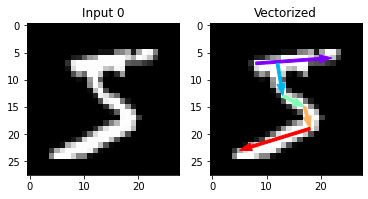

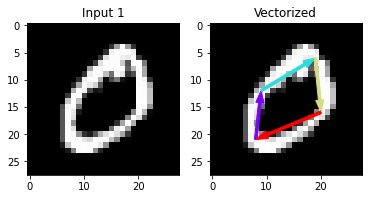

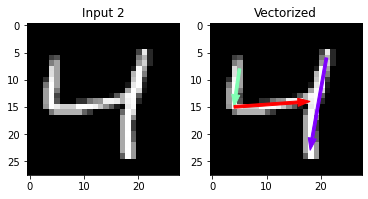

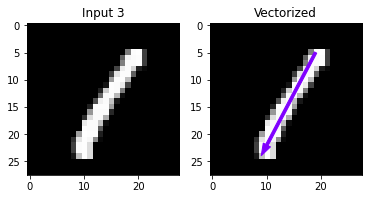

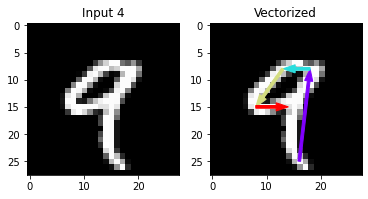

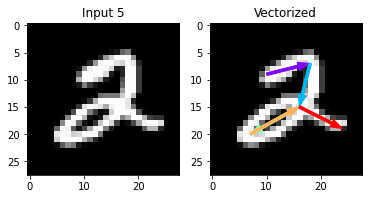

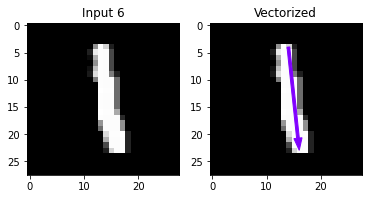

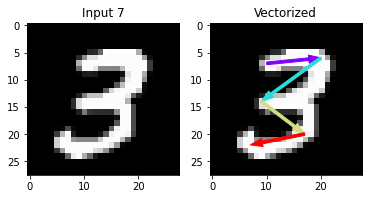

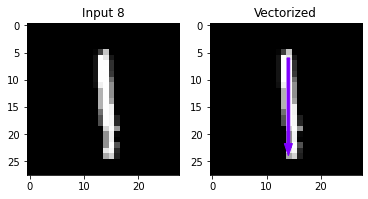

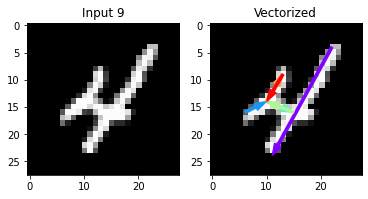

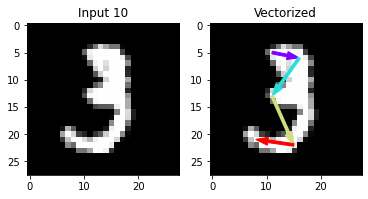

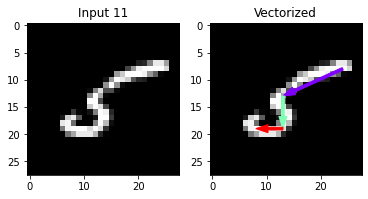

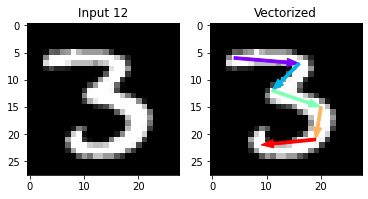

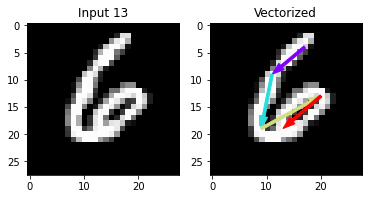

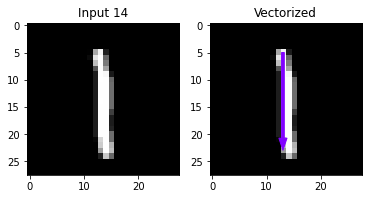

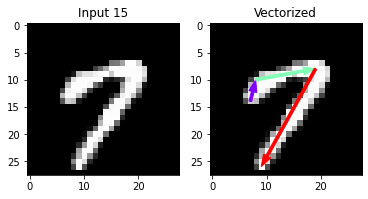

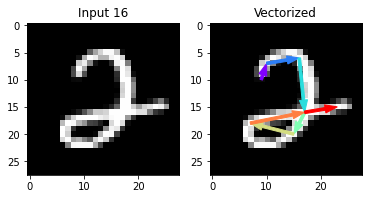

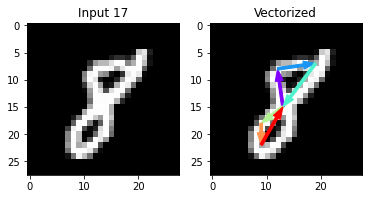

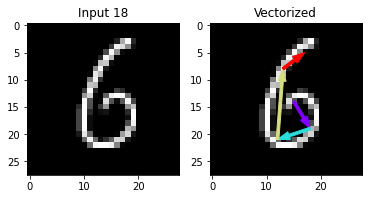

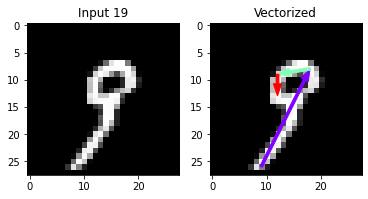

In [63]:
digits = np.arange(20)
filters = get_filters_multi_scale()

for d in digits:
    test_image = x_train[d] / 255.

    sequence = vectorize_digit(test_image, filters, do_plot=False, verbose=False)

    rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

    fig = plt.figure()
    plt.subplot(121)
    plt.title("Input {}".format(d))
    plt.imshow(rgb_im)
    plot_vectors(rgb_im, sequence, fig, subplot='122', title="Vectorized")

# TEST MULTI SCALE PRIMERS

shape filter_top_t (9, 7, 7)
shape filter_top_t (7, 7, 1, 9)
[[0.722 0.    0.    0.    0.    0.    0.   ]
 [0.161 0.    0.    0.    0.251 0.169 0.   ]
 [0.027 0.    0.376 0.929 0.996 0.969 0.42 ]
 [0.    0.024 0.875 0.329 0.051 0.341 0.965]
 [0.    0.22  0.592 0.    0.    0.    0.576]
 [0.    0.051 0.075 0.    0.    0.    0.165]
 [0.    0.    0.    0.    0.    0.    0.055]]
shape test_image (1, 28, 28, 1)
shape primers (1, 28, 28, 9)
min max prim0 (28, 28) 0.0 0.18529409
min max prim1 (28, 28) 0.0 0.2997549
min max prim2 (28, 28) 0.0 0.31691176
min max prim3 (28, 28) 0.0 0.35539216
min max prim4 (28, 28) 0.0 0.3950981
min max prim5 (28, 28) 0.0 0.10454115
min max prim6 (28, 28) 0.0 0.30501157
min max prim7 (28, 28) 0.0 0.56939524
min max prim8 (28, 28) 0.0 0.7845001
shape max_prim (28, 28)


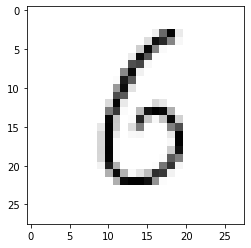

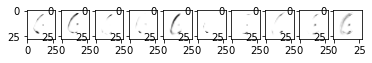

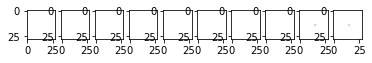

In [27]:
# end primers
large = np.array([[-2., -2., -2., -2., -2., -2., -2.],
                  [-2., -2., -2., -2., -1., -2., -2.],
                  [-2., -.5, -.5, -.5, -.5, -.5, -2.],
                  [-2., -.5, 1.0, 1.0, 1.0, -.5, -2.],
                  [-2., 0.0, 1.0, 1.0, 1.0, 0.0, -2.],
                  [-2., 0.0, 1.0, 1.0, 1.0, 0.0, -2.],
                  [-2., 0.0, 1.0, 1.0, 1.0, 0.0, -2.]]) / 12

medium = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                   [-1., -1., -.5, -.5, -1., -1., -1.],
                   [-1., -.5, 0.0, 0.0, -.5, -1., -1.],
                   [-1., 0.0, 1.0, 1.0, 0.0, -1., -1.],
                   [-1., 0.0, 1.0, 1.0, 0.0, -1., -1.],
                   [-.5, 0.0, 1.0, 1.0, 0.0, -.5, -1.],
                   [-.5, 0.0, 1.0, 1.0, 0.0, -.5, -1.]]) / 8

medium_shift_left = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                              [-1., -1., -1., -1., -1., -1., -1.],
                              [-1., -.5, -.5, -.5, -.5, -1., -1.],
                              [-1., -.5, 1.0, 1.0, -.5, -.5, -1.],
                              [-1., -.5, -.5, 1.0, 1.0, -.5, -1.],
                              [-1., -1., -.5, 1.0, 1.0, -.5, -1.],
                              [-1., -1., -.5, 0.0, 1.0, 1.0, -1.]]) / 8

medium_shift_right = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                               [-1., -1., -1., -1., -1., -1., -1.],
                               [-1., -1., -.5, -.5, -.5, -.5, -1.],
                               [-1., -.5, -.5, 1.0, 1.0, -.5, -1.],
                               [-1., -.5, 1.0, 1.0, -.5, -.5, -1.],
                               [-1., -.5, 1.0, 1.0, -.5, -1., -1.],
                               [-.5, 1.0, 1.0, 0.0, -.5, -1.0, -1.]]) / 8

small_shift_left = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                             [-1., -1., -.5, -1., -1., -1., -1.],
                             [-1., -.5, 0.0, 0.0, -.5, -1., -1.],
                             [-.5, 0.0, 1.0, 1.0, -.5, -.5, -1.],
                             [-1., -.5, 1.0, 1.0, 1.0, -.5, -1.],
                             [-1., -.5, 1.0, 1.0, 1.0, 1.0, -.5],
                             [-1., -1., -.5, 1.0, 1.0, 1.0, -.5]]) / 12

custom1 = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                               [-1., -1., -1., -1., -1., -1., -1.],
                               [-1., -1., -1., -1., -1., -1., -1.],
                               [-1., -1., -1., 0.03, 0.03, -1., -1.],
                               [-1., -1., 0.3, 0.9, 0.3, -1., -1.],
                               [-1., -1., 0.7, 1.0, 0.3, -1., -1.],
                               [-1., 0.5, 0.9, 0.8, -1., -1., -1.]]) / 5.76

custom2 = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                    [-1., -1., 0.153, 0.627, -1., -1., -1.],
                    [-1., -1., 0.486, 0.945, 0.125, -1., -1.],
                    [-1., -1., 0.263, 0.996, 0.204, -1., -1.],
                    [-1., -1., 0.078, 0.882, 0.498, -1., -1.],
                    [-1., -1., -1., 0.812, 0.875, -1., -1.],
                    [-1., -1., -1., 0.616, 0.875, -1., -1.]]) / 8.435

custom3 = np.array([[-1., -1., -1., -1., -1., -1., -1.],
                    [-1., 0.157, 0.067, 0., -1., -1., -1.],
                    [-2., 0.98, 0.561, 0., -1., -1., -1.],
                    [-2., 0.663, 0.867, 0.039, -2., -1., -1.],
                    [-2., 0.133, 0.949, 0.561, 0.008, -2., -1.],
                    [-1., -2., 0.227, 0.969, 0.722, 0.055, -1.],
                    [-1., -1., -2., 0.294, 0.961, 0.784, 0.11]]) / 9.107

custom4 = np.array([[-1.  , -1.  , -1.  , -1.  , 0.   , 0.   , 0.0],
                     [-1.  , 0.051, 0.22 , 0.024, -1.  , -1.  , -1.   ],
                     [-1.  , 0.075, 1.   , 1.   , 0.376, -1.  , -1.   ],
                     [-1.  , -1.  , -1.  , 1.   , 1.   , -1.  , -1.  ],
                     [-1.  , -1.  , -1.  , 0.051, 1.   , 0.251, -1.  ],
                     [-1.  , -1.  , -1.  , 0.341, 1.   , 0.169, -1.  ],
                     [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])/6.5
# custom4 = np.rot90(custom4, 3)
# print("custom4", np.sum(custom4))
# print(custom4)


# # T primers
# large = np.array([[-1., -1., -1., -1., -1., -1., -1.],
#                      [0.0, -.5, -.5, -.5, -.5, -.5, 0.0],
#                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
#                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
#                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
#                      [-2., -3., 1.0, 1.0, 1.0, -3., -2.],
#                      [-6., 0.0, 1.0, 1.0, 1.0, 0.0, -6.]]) / 27
#
# medium = np.array([[-1., -1., -2., -2., -1., -1., 0.0],
#                      [-.5, -.5, -1., -1., -.5, -.5, 0.0],
#                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
#                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
#                      [-1., -2., 1.0, 1.0, -2., -1., 0.0],
#                      [-1., -1., 1.0, 1.0, -1., -1., 0.0],
#                      [-2., 0.0, 1.0, 1.0, 0.0, -2., 0.0]]) / 18
#
# medium_shift_left = np.array([[1.0, -.5, -1., -2., -1., -1., 0.0],
#                               [1.0, 1.0, -1., -1., -.5, -.5, 0.0],
#                               [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
#                               [-.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0],
#                               [-1., -2., 1.0, 1.0, -1., -1., 0.0],
#                               [-1., -1., 1.0, 1.0, -.5, -1., 0.0],
#                               [-2., -1., 0.0, 1.0, 1.0, -1., 0.0]]) / 18
#
# medium_shift_right = np.zeros((7, 7))
# small_shift_left = np.zeros((7, 7))

# # corner primers
# large = np.array([[-4., -4., -4., -4., -4., -4., -2.],
#                          [-4., -2., -2., -2., -2., -2., 0.0],
#                          [-4., -2., 1.0, 1.0, 1.0, 1.0, 1.0],
#                          [-4., -2., 1.0, 1.0, 1.0, 1.0, 1.0],
#                          [-4., -2., 1.0, 1.0, 1.0, 1.0, 1.0],
#                          [-4., -2., 1.0, 1.0, 1.0, -1., 0.0],
#                          [-2., 0.0, 1.0, 1.0, 1.0, 0.0, -2.]]) / 21
#
# medium =  np.array([[-2., -2., -2., -2., -2., -2., -2.],
#                      [-2., -1., -1., -.5, -.5, -.5, 0.0],
#                      [-2., -1., 1.0, 1.0, 1.0, 1.0, 0.5],
#                      [-2., -.5, 1.0, 1.0, 1.0, 1.0, 0.5],
#                      [-2., -.5, 1.0, 1.0, -.5, -.5, 0.0],
#                      [-2., 0.0, 1.0, 1.0, -.5, -1., -1.],
#                      [0.0, 0.0, 0.5, 0.5, 0.0, -1., 0.0]]) / 13
#
#
# medium_shift_left = np.array([[-2., -2., -2., -2., -1., 0.0, 1.0],
#                             [-2., -1., -1., -.5, 1.0, 1.0, 1.0],
#                             [-2., -1., 0.0, 1.0, 1.0, 1.0, 0.0],
#                             [-2., -.5, 1.0, 1.0, -.5, -1., 0.0],
#                             [-1., -.5, 1.0, 1.0, -.5, -1., 0.0],
#                             [-1., 0.0, 1.0, 1.0, 0.0, -1., 0.0],
#                             [-1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) / 14
#
# medium_shift_right =  np.array([[-2., -2., -1., -1., -1., -.5, 0.0],
#                                 [-1., -1., -1., -1., -.5, -.5, 0.0],
#                                 [-1., -.5, 1.0, 1.0, 1.0, 1.0, 0.0],
#                                 [-1., 0.0, 1.0, 1.0, 1.0, 1.0, 0.0],
#                                 [-1., 1.0, 1.0, 0.0, -1., -1., 0.0],
#                                 [-.5, 1.0, 1.0, -.5, -1., -1., 0.0],
#                                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) / 12
#
# small_shift_left = np.array([[-2., -2., -2., -2., -1., 0.0, 0.0],
#                              [-2., -1., -1., -1., 0.0, 1.0, 0.0],
#                              [-2., -1., 0.0, 1.0, 1.0, 0.0, 0.0],
#                              [-2., -.5, 1.0, 1.0, -.5, -1., 0.0],
#                              [-1., -.5, 1.0, 0.0, -.5, -1., 0.0],
#                              [-1., 0.0, 1.0, 0.0, 0.0, -1., 0.0],
#                              [-1., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) / 7
#
# custom1 = np.array([[-5.,    0.125, 0.051, 0.075, -5.   , -5.    ,-5.   ],
#                      [-5.,    0.898, 0.843, 0.737, 0.361, 0.031, -5.   ],
#                      [-5.,    0.796, 0.996, 1.   , 0.996, 0.914, 0.416],
#                      [-5.,    0.043, 0.373, 0.686, 0.992, 0.992, 0.957],
#                      [-5.,    -1.   , 0.118, 0.522, 0.992, 0.914, 0.996],
#                      [-5.,    -1.   , 0.184, 0.992, 0.894, 0.188, 0.667],
#                      [-5.,    -1.   , 0.184, 0.992, 0.631, -10.   , 0.141]]) / 20.7
#
# custom2 = np.zeros((7, 7))

# # cross primers
# large = np.array([[-1., 0.0, 0.0, 1.0, 0.0, 0.0, -1.],
#                   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
#                   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
#                   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
#                   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
#                   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
#                   [-1., 0.0, 0.0, 1.0, 0.0, 0.0, -1.]]) / 17
#
# medium = np.array([[1.0, 0.0, -1., -1., -1., 0.0, 1.0],
#                    [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                    [-1., 0.0, 1.0, 0.0, 1.0, 0.0, -1.],
#                    [-1., 0.0, 0.0, 1.0, 0.0, 0.0, -1.],
#                    [-1., 0.0, 1.0, 0.0, 1.0, 0.0, -1.],
#                    [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                    [1.0, 0.0, -1., -1., -1., 0.0, 1.0]]) / 12
#
# medium_shift_left = np.array([[1.0, 0.0, 0.0, -1.5, 0.0, 0.0, 1.0],
#                                [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                                [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0],
#                                [-1.5, 0.0, 1.0, 1.0, 1.0, 0.0, -1.5],
#                                [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0],
#                                [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                                [1.0, 0.0, 0.0, -1.5, 0.0, 0.0, 1.0]]) / 17
#
# medium_shift_right = np.array([[0.0, 0.0, -2., -2., -1., 0.0, 1.0],
#                                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                                [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, -2.],
#                                [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0],
#                                [-2., 0.0, 1.0, 0.0, 1.0, 1.0, 1.0],
#                                [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                                [1.0, 0.0, -1., -2., -2., 0.0, 0.0]]) / 15
# small_shift_left = np.zeros((7, 7))
# custom1 = np.array([[-5.    ,-5.    ,0.027 ,0.843 , 0.996, 0.502, -5.   ],
#                      [-5.   ,-5.    ,0.153 ,0.996 , 0.996, 0.22 , -5.   ],
#                      [0.027, 0.137, 0.384, 0.996, 0.996, 0.816, 0.616],
#                      [0.831, 0.996, 0.996, 0.996, 0.996, 0.984, 0.875],
#                      [0.894, 0.98 , 0.996, 0.996, 0.604, 0.196, -5.   ],
#                      [-5.   , 0.847, 0.996, 0.863, 0.047, -5.   , -5.   ],
#                      [0.537, 0.957, 0.91 , 0.196, -5.   , -5.   , -5.   ]]) / 25.398
# custom2 = np.zeros((7, 7))

# filter_top_t = np.array([large, medium])
filter_top_t = np.array([large, medium, medium_shift_left, medium_shift_right, small_shift_left, custom1, custom2, custom3, custom4])
print("shape filter_top_t", np.shape(filter_top_t))

num_rotate = 1
filter_top_t = np.rot90(filter_top_t, num_rotate, axes=(1, 2))

filter_top_t = np.expand_dims(filter_top_t, axis=3)
filter_top_t = np.moveaxis(filter_top_t, 0, -1)
print("shape filter_top_t", np.shape(filter_top_t))
n_filters = np.shape(filter_top_t)[-1]

# convert to tf
tf.convert_to_tensor(filter_top_t, dtype='float32')

# load image
# idx = 0  # label 5
# idx = 1  # label 0
# idx = 2  # label 4
# idx = 3  # label 1
# idx = 4  # label 9
# idx = 5  # label 2
# idx = 7  # label 3
# # idx = 8  # label 1
# idx = 9  # label 4
# idx = 10  # label 3
# idx = 11  # label 5
# # idx = 12  # label 3
# idx = 13  # label 6
# idx = 16  # label 2
# idx = 17  # label 8
idx = 18  # label 6
test_image = x_train[idx] / 255.

# plot image
fig = plt.figure()
plt.imshow(test_image, cmap='Greys')
print(test_image[11:18, 12:19])

# transform to fit tf
test_image = np.expand_dims(test_image, axis=[0, 3])
print("shape test_image", np.shape(test_image))
test_image = tf.convert_to_tensor(test_image, dtype='float32')


# apply convolution
primers = tf.nn.conv2d(test_image, filter_top_t, strides=1, padding='SAME', name="conv1")
primers = primers.numpy()
print("shape primers", np.shape(primers))

# apply relu activation
for i in range(n_filters):
    prim = primers[0, ..., i]
    prim[prim < 0] = 0
    print("min max prim{} {}".format(i, np.shape(prim)), np.amin(prim), np.amax(prim))
max_prim = np.amax(primers, axis=(0, -1))
print("shape max_prim", np.shape(max_prim))

plt.figure()

for i in range(n_filters):
    plt.subplot(1, n_filters + 1, i + 1)
    plt.imshow(primers[0, ..., i], cmap='Greys')

plt.subplot(1, n_filters + 1, i + 2)
plt.imshow(max_prim, cmap='Greys')

threshold = 0.7

for i in range(n_filters):
    prim = primers[0, ..., i]
    prim[prim < threshold] = 0
max_prim[max_prim < threshold] = 0

plt.figure()
for i in range(n_filters):
    plt.subplot(1, n_filters + 1, i + 1)
    plt.imshow(primers[0, ..., i], cmap='Greys')

plt.subplot(1, n_filters + 1, i + 2)
plt.imshow(max_prim, cmap='Greys')